###Imports, Mount Drive

In [0]:
# I took this kaggle problem
# I tried to solve it in pytorch
# This network here does not learn the task correctly. Try to make it work

#https://www.kaggle.com/karanjakhar/facial-keypoint-detection
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

In [0]:
drive.mount('/content/drive/', force_remount=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
%cd '/content/drive/My Drive/Applied 2020.06.06/Week 1 Materials'
!ls

/content/drive/My Drive/Applied 2020.06.06/Week 1 Materials
'1- mnist_classification_dense_tensorflow.ipynb'   GANExample.ipynb
'2- mnist_classification_conv_kerasF.ipynb'	   Programme.txt
'3- cifar_classification_conv_kerasS.ipynb'	   training.csv
'4- kaggle_localisation_conv_keras.ipynb'	   training.zip
'4- kaggle_localisation_conv_pytorch.ipynb'	  'Week 1.gslides'
'5- segmentation_conv_pytorch.ipynb'		  'z1- Pytorch.ipynb'
'Applied AI Week 1.gdoc'


###Data Examination

In [0]:
#!unzip training.zip
#!ls

In [0]:
data = pd.read_csv('training.csv') 
print(data.head())
print(data.isnull().any().value_counts())
data.fillna(method = 'ffill',inplace = True)
print(data.isnull().any().value_counts())

   left_eye_center_x  ...                                              Image
0          66.033564  ...  238 236 237 238 240 240 239 241 241 243 240 23...
1          64.332936  ...  219 215 204 196 204 211 212 200 180 168 178 19...
2          65.057053  ...  144 142 159 180 188 188 184 180 167 132 84 59 ...
3          65.225739  ...  193 192 193 194 194 194 193 192 168 111 50 12 ...
4          66.725301  ...  147 148 160 196 215 214 216 217 219 220 206 18...

[5 rows x 31 columns]
True     28
False     3
dtype: int64
False    31
dtype: int64


In [0]:
datalen = 7049
trainlen = 7000

Training

In [0]:
pixel_list = []
for i in range(0,datalen):
    row = data['Image'][i].split(' ')
    pixel = ['0' if x == '' else x for x in row]
    pixel_list.append(pixel)

In [0]:
# Pytorch takes channels in the second dimension. For that, I swap axes (dimensions)
input_tensor = np.array(pixel_list,dtype = 'float')
print(np.shape(input_tensor))
input_tensor = input_tensor.reshape(-1,96,96,1)
input_tensor = np.swapaxes(input_tensor,2,3)
input_tensor = np.swapaxes(input_tensor,1,2)
print(np.shape(input_tensor))

(7049, 9216)
(7049, 1, 96, 96)


In [0]:
labels = data.drop('Image',axis = 1)

label_list = []
for i in range(0,datalen):
    label = labels.iloc[i,:]
    label_list.append(label)
label_tensor = np.array(label_list,dtype = 'float')

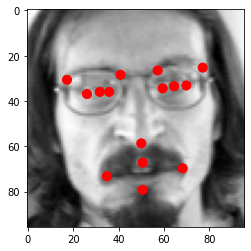

In [0]:
from matplotlib.pyplot import Circle

index = random.randint(0,1000)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(input_tensor[index].reshape(96,96),cmap='gray')

for xx, yy in label_tensor[index].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)

In [0]:
inp_and_label = []
for i in range(trainlen):
   inp_and_label.append([input_tensor[i], label_tensor[i]])

# we use Dataloader objects in pytorch to easily iterate on our dataset while performing training loops
trainloader = torch.utils.data.DataLoader(inp_and_label, shuffle=True, batch_size=500)
i1, l1 = next(iter(trainloader))
print(i1.shape,l1.shape)

torch.Size([500, 1, 96, 96]) torch.Size([500, 30])


### Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# we write our networks as class instances. dont forget to inherit from nn.Module
class Net(nn.Module):
    # we always need an init method to define our output matrices (similar to nodes in graph)
    # we need batch norms but i cannot make it run with batch norms
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 5)
        self.conv4_bn = nn.BatchNorm2d(256)


                                
        
        self.fc1 = nn.Linear(512 * 34 * 34, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 30)
        
    # we always need an forward method to draw our computational graph (similar to completing the graph with edges)
    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1_bn(self.conv1(x))))
        x = F.sigmoid(self.conv2_bn(self.conv2(x)))
        x = F.sigmoid(self.conv3_bn(self.conv3(x)))
        x = F.sigmoid(self.conv4_bn(self.conv4(x)))

        # vectorize (flatten)
        x = x.reshape(-1, 512 * 25 * 25)

        #x = F.sigmoid(self.fc1_bn(self.fc1(x)))
        #x = F.sigmoid(self.fc2_bn(self.fc2(x)))

        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
# i couldnt run the previous cell without errors, so i am omitting batch norms.
# but now, it will not learn correctly
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 30)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.reshape(-1, 64 * 21 * 21)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [0]:
net = net.float()

In [0]:
#we get info on our gpu, put it in the variable "device"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#we carry our model into gpu
net.to(device)



cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)

In [0]:
# our training loop

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0

    # here we use the dataloader object. it performs .next() operation in each iteration of the loop
    # we also group our batches with numbers. we do this with enumerate. we do this so we can know in which batch we are 
    for i, data in enumerate(trainloader, start = 0):
        # get the inputs; data is a list of [inputs, labels]

        #inputs, labels = data
        inputs, labels = data[0].float().to(device), data[1].float().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('Epoch %d Loss: %.3f' %
                  (epoch + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 Loss: 1.345
Epoch 2 Loss: 1.316
Epoch 3 Loss: 1.252
Epoch 4 Loss: 1.165
Epoch 5 Loss: 1.047
Epoch 6 Loss: 0.910
Epoch 7 Loss: 0.783
Epoch 8 Loss: 0.670
Epoch 9 Loss: 0.570
Epoch 10 Loss: 0.483
Finished Training


In [0]:
test = []
for i in range(trainlen,datalen):
   test.append([input_tensor[i], label_tensor[i]])

testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=500)
i1, l1 = next(iter(testloader))
print(i1.shape,l1.shape)

torch.Size([49, 1, 96, 96]) torch.Size([49, 30])


In [0]:
# In pytorch, dont forget to perform testing evaluations with no_grad. Or else, it 
# fills the memory of the gpu and it eventually makes you restart the computer.

# If we train enough, we see that our network makes almost identical predictions for each image
# this is not good.
# We may try to solve this with changing the model structure, making it deeper, adding batch norm, etc.

from matplotlib.pyplot import Circle
randomsayi = random.randint(0,49)

#inputs = torch.tensor(input_tensor[randomsayi:randomsayi+2].reshape((2,1,96,96))).float().to(device)
#labels = torch.tensor(label_tensor[randomsayi:randomsayi+2]).float().to(device)

print(np.shape(inputs))
preds = net(inputs).cpu()


fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(inputs[randomsayi].cpu().view((96,96)),cmap = 'gray')

for xx, yy in preds[randomsayi].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)


torch.Size([500, 1, 96, 96])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: ignored

torch.Size([500, 1, 96, 96])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


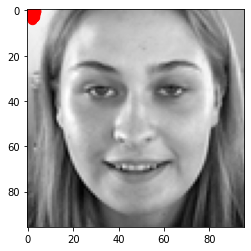

In [0]:
from matplotlib.pyplot import Circle
randomsayi = random.randint(0,49)

#inputs = torch.tensor(input_tensor[randomsayi:randomsayi+2].reshape((2,1,96,96))).float().to(device)
#labels = torch.tensor(label_tensor[randomsayi:randomsayi+2]).float().to(device)

print(np.shape(inputs))
preds = net(inputs).cpu()


fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(inputs[randomsayi].cpu().view((96,96)),cmap = 'gray')

for xx, yy in preds[randomsayi].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)


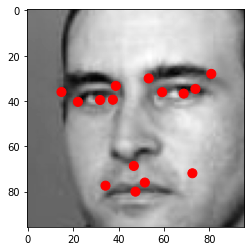

In [0]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(inputs[randomsayi].cpu().view((96,96)),cmap = 'gray')

for xx, yy in labels[randomsayi].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)